# Raw Convnet 
## 2 convolutional layers with pooling and batchnorm
## 2 fully connected layers

In [8]:
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = MNIST('../data')
train_images, train_labels = data.load_training()
test_images, test_labels = data.load_testing()


In [10]:
## sanity check 
#check the data was imported correctly as usual

print(' Number of training images - {}\n Number of training labels - {}'.format(len(train_images), len(train_labels)))
print(' Number of test images -{}\n Number of test labels - {}'.format(len(test_images), len(test_labels)))

 Number of training images - 60000
 Number of training labels - 60000
 Number of test images -10000
 Number of test labels - 10000


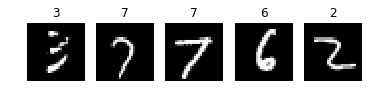

In [11]:
## Visualise the data
samples = np.random.randint(60000, size=5)

for idx, sample in enumerate(samples):
    image = np.asarray(train_images[sample]).reshape(28, 28)
    label = train_labels[sample]
    
    plt.subplot(1, 5, idx+1)
    plt.imshow(image,cmap='gray')
    plt.title(label)
    plt.axis('off')

In [13]:
#image data is fine but the arrays are fine but are in the wrong shape... 
#images are currently in a long row vector need to have spacial information for cnn to be effective 

print('initially shape of image data was - {}'.format(np.asarray(train_images).shape)) #60000 * 784

#first change to NP array
train_data = np.array(train_images)
test_data  = np.array(test_images)

#reshape
train_data = train_data.reshape(60000,28, 28)
test_data = test_data.reshape(10000,28, 28)

print('after re-shape its now - {}'.format(np.asarray(train_data).shape)) #60000 * 28 *28



initially shape of image data was - (60000, 784)
after re-shape its now - (60000, 28, 28)


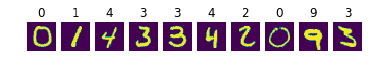

In [14]:
#sanity check for new data
#prove it is correct shape
samples = np.random.randint(60000, size = 10)
for idx, sample in enumerate(samples):
    image = train_data[sample]
    label = train_labels[sample]
    plt.subplot(1, 10, idx+1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')

In [15]:
#I will also conver the labels into one-hot vectors
#such that the position of the number '1' inside the vector indicates its label

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
train_images = np.array(train_images)
test_images = np.array(test_images)

train_labels_v = np.zeros((60000,10))
train_labels_v[np.arange(60000), train_labels] = 1

test_labels_v = np.zeros((10000,10))
test_labels_v[np.arange(10000), test_labels] = 1

##Sanity check:

samples = np.random.randint(60000, size=3)

for sample in samples:
    print('the number - {}'.format(train_labels[sample]))
    print('is represented by the one-hot vector: ', train_labels_v[sample])
    print('\n')

the number - 8
is represented by the one-hot vector:  [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


the number - 6
is represented by the one-hot vector:  [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


the number - 7
is represented by the one-hot vector:  [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]




In [ ]:
# Lets train this data!
# network structure:
# ConvLayer1 -> relu ->  convlayer2 -> relu -> -> FCLayer 1 -> FCLayer 2 -> output
#

In [193]:
class Model:
    
    def __init__(self, input_dims=28, num_filters=(16, 32), filter_sz=5,
                 sample_sz=2, num_classes=10, weight_scale=1e-4, initial_params=(1,2)):
        
        num_l1_filters, num_l2_filters = num_filters
        self.stride, self.pad = initial_params
        
        #initialize the conv filters
        self.c1_filters = np.random.normal(scale=weight_scale, size=(num_l1_filters, 1, filter_sz, filter_sz))
        self.c1_b = np.zeros([num_l1_filters])
        self.c2_filters = np.random.normal(scale=weight_scale, size=(num_l2_filters, 1, filter_sz, filter_sz))
        self.c2_b = np.zeros([num_l2_filters])
        
        #initialize the affine layer weights
        self.fc_W1 = np.random.normal(scale=weight_scale, size=(28*28 * 32, 100))
        self.fc_b1 = np.zeros([100])
        self.fc_W2 = np.random.normal(scale=weight_scale, size=(100, num_classes))
        self.fc_b2 = np.zeros([10])
        
    def convForward(self, x, k, b):
        stride, pad = self.stride, self.pad
        N = x.shape[0]
        H, W = x[0][0].shape[0], x[0][0].shape[1]
        F = k.shape[0]
        HH, WW = k[0][0].shape[0], k[0][0].shape[1]
        
        h_out = int(1+ (H - HH + (2 * pad)) / stride )
        w_out = int(1+ (W - WW + ((2 * pad))) / stride )
        
        x_pad = np.pad((x), ( (0,), (0,), (pad,), (pad,)), 'constant')
        output = np.zeros((N, F, h_out, w_out))
        for n in range(N):
            for f in range(F):
                for h in range(h_out):
                    for w in range(w_out):
                        output[n, f, h, w] = np.sum((x_pad[n, :, (h * stride) : ((h+HH)*stride), (w * stride) : ((w+WW)*stride)] * k[f])+ b[f])
        
        cache = (x, k, b)
        return output, cache
    
    
    
    def convBackward(self, dout, cache):
        
        x, k, b = cache
        stride, pad = self.stride, self.pad
        
        N, F, Hh, Ww = dout.shape
        N, C, H, W = x.shape
        F, Ch, HH, WW = k.shape
        print(x.shape)
        print(dout.shape)
        
        db = np.zeros((F))
        for f in range(F):
            db[f] = np.sum(dout[:,f,:,:])##shape
            
            
        xout = np.pad(x, ((0,), (0,), (pad,), (pad,)), 'constant')
        dw = np.zeros((F, C, HH, WW))
        
        for f in range(F):
            for c in range(Ch):
                for h in range(HH):
                    for w in range(WW):
                        sub_x = xout[:, c, h:(h + Hh *stride): stride, w:(w+Ww *stride):stride] #which part of X_pad did you affect
                        dw[f, c, h, w] = np.sum(dout[:,f,:,:] * sub_x)
                        

                    
        dx = np.zeros((N, C, H, W))
        for n in range(N):
            for h in range(H):
                for w in range(W):
                    for f in range(F):
                        for hh in range(Hh):
                            for ww in range(Ww):
                                mask1 = np.zeros_like(k[f, :, :, :]) #which part of the mask did you mingle with
                                mask2 = np.zeros_like(k[f, :, :, :])
                                if (h + pad-hh * stride) < HH and (h + pad -hh *stride) >=0:
                                      mask1[:, h + pad - hh * stride, :] = 1.0
                                if (W + pad - ww * stride) < WW and (W + pad - ww * stride) >= 0:
                                    mask2[:, :, W + pad - ww * stride] = 1.0
                                w_masked = np.sum(k[f, :, :, :] * mask1 * mask2, axis=(1, 2))
                                dx[n, :, h, w] += dout[n, f, hh, ww] * w_masked
                                
        return {'b':db, 'x':dx, 'w':dw}
                    
                    
    def fc_forward(self, x):
        relu = lambda x: np.maximum(0, x)
            
        a1 = x.dot(self.fc_W1) + self.fc_b1
        a1_relu = relu(a1)
        scores = a1_relu.dot(self.fc_W2) + self.fc_b2 #logits
            
        return scores, (x, a1, a1_relu)
             
        
    def fc_backward(self, y, y_cls, scores, cache, reg=0.05):
        x, a1, a1_relu = cache
        N = y.shape[0]
        probabilities = self.softmax(scores)
        loss = self.c_e_loss(probabilities, y_cls)
            
        data_loss = loss
        reg_loss = reg * 0.5 * np.sum(self.fc_W1*self.fc_W1) + reg * 0.5 * np.sum(self.fc_W2*self.fc_W2)
            
        loss = data_loss + reg_loss
        dscores = probabilities
        dscores[range(N),y_cls] =-1
        dscores /= N
        

        db2 = np.sum(dscores, axis=0)
        dW2 = np.dot(a1_relu.T, dscores)
            
        d_reluIn = a1_relu
        d_reluIn[a1 <= 0] = 0
        
        db1 = np.sum(d_reluIn, axis=0)
        dW1 = np.dot(x.T, d_reluIn)
        dx  = np.dot(d_reluIn, self.fc_W1.T)                   
            
        return {"b1": db1, "d2": db2, "W1": dW1, "W2": dW2, "x": dx}
    
    
    def softmax(self, scores):
        scores -= np.max(scores, axis=1, keepdims=True)
        e_scores = np.exp(scores)
        return e_scores/ np.sum(e_scores, axis=1, keepdims=True) 
    
    def c_e_loss(self, probs, labels):
        N = probs.shape[0]
        print(labels.shape)
        print("N", N)
        return (np.sum(-np.log(probs[range(N), labels])) / N)
        
        
    def loss(x, y, y_gt, reg, num_iterations, sample_size, learning_rate):
        
        num_samples = x.shape[0]
        num_epochs = sample_size / num_samples
        
        for it in range(num_iterations):
            batch_idx = np.random.randint(num_samples, size=sample_size)
            
            y_batch = y[batch_idx]    
            y_batch_cls = y_gt[batch_idx]
            x_batch = x[batch_idx]
            #
            # FORWARD PASS
            #
            # conv layers
            c1_out, c1_cache = self.convForward(x_batch, self.c1_filters, self.c1_b)
            
            c2_out, c2_cache = self.convForward(c1_out, self.c2_filters, self.c2_b)
            
            # fc layers
            # stretch out input - reshape
            fc_in_flat = c2_out.reshape(c2_out.shape[0], -1)
            
            # fc layer
            scores, fc_cache = self.fc_forward(fc_in_flat)
                 
            
            #
            # BACKWARD PASS
            #
            fc_grads =  self.fc_backward(y_batch, y_batch_cls, scores, fc_cache)
            #
            # (UN)Reshape -- change back to shape of kernels
            fc_grads['x'] = fc_grads['x'].reshape(c2_out.shape)
            
            #
            #
            c2_grads = self.convBackward(fc_grads['x'], c2_cache)
            c1_grads = self.convBackward(c2_grads['x'], c1_cache)
            
            
            ##
            ## update weights and bias' here
            ##
            
    
    def predict(self, x):
        c1_out, _ = self.convForward(x, self.c1_filters, self.c1_b)
        c2_out, _ = self.convForward(c1_out, self.c2_filters, self.c2_b)
        fc_in_flat = c2_out.reshape(c2_out.shape[0], -1)
        scores = self.fc_forward(fc_in_flat)
        
        return np.argmax(scores, axis=1)
    
    
    def backpred(self, x, y, y_cls, sco, cache):

        c1_out, c1_cache = self.convForward(x, self.c1_filters, self.c1_b)
        c2_out, c2_cache = self.convForward(c1_out, self.c2_filters, self.c2_b)
        fc_in_flat = c2_out.reshape(c2_out.shape[0], -1)
        print("flatening shape: ", fc_in_flat.shape)
        probs, cache  = self.fc_forward(fc_in_flat)
        
        fc_grads =  self.fc_backward(y, y_cls, sco, cache)
        print("dx, shape: ", fc_grads['x'].shape)
        print("dw1, shape: ", fc_grads['W1'].shape)
        print("dw2, shape: ", fc_grads['W2'].shape)
        fc_grads['x'] = fc_grads['x'].reshape(c2_out.shape)
        c2_grads = self.convBackward(fc_grads['x'], c2_cache)
        c1_grads = self.convBackward(c2_grads['x'], c1_cache)
        
        
            

In [194]:
## train model on dataset 
model = Model(initial_params=(1,2))


In [195]:
print(test_data.shape)

(10000, 28, 28)


In [196]:
a = test_data[0:2]#[np.newaxis, np.newaxis, :]
print(a.shape)
a = a[:, np.newaxis,:,:]
print(a.shape)
print(test_data.shape)
print(a.shape)
ay = test_labels[0:2]
ay_cls = test_labels[0:2].astype(int)
print(ay)
print(ay_cls)

(2, 28, 28)
(2, 1, 28, 28)
(10000, 28, 28)
(2, 1, 28, 28)
[7 2]
[7 2]


In [59]:
#probs, cache = model.predict(a)
#print(probs.shape)

(2, 10)


In [197]:
thing1, thing2 = model.backpred(a, ay, ay_cls, probs, cache)

flatening shape:  (2, 25088)
(2,)
N 2
dx, shape:  (2, 25088)
dw1, shape:  (25088, 100)
dw2, shape:  (100, 10)
(2, 16, 28, 28)
(2, 32, 28, 28)


KeyboardInterrupt: 